In [1]:
## Partially copied from uvw_calc_05222016 for Ly's pilot survey fields 

In [2]:
import pyfits
import glob
from astropy.io import ascii
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
import os
import pylab as pl
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import ICRS, Galactic
from astropy.table import Table, join 

from galpy.util.bovy_coords import radec_to_lb
from galpy.util.bovy_coords import vrpmllpmbb_to_vxvyvz
from galpy.util.bovy_coords import pmrapmdec_to_pmllpmbb
from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.potential import vesc
from galpy.potential import KeplerPotential
from galpy.util import bovy_conversion

%matplotlib inline

In [3]:
font={'family': 'serif', 
       'weight': 'normal', 
        'size' : 11, 
        'style' : 'normal' }
plt.rc('font', **font)
plt.rc('xtick', color='k', labelsize='medium', direction='in')
plt.rc('xtick.major', size=6, pad=4)
plt.rc('xtick.minor', size=3, pad=4)
plt.rc('ytick.major', size=6, pad=4)
plt.rc('ytick.minor', size=3, pad=4)

In [4]:
def gal_uvw(distance=None, lsr=None, ra=None, dec=None, pmra=None, pmdec=None, vrad=None, plx=None):
    #     U - Velocity (km/s) positive toward the Galactic *anti*center
    #     V - Velocity (km/s) positive in the direction of Galactic rotation
    #     W - Velocity (km/s) positive toward the North Galactic Pole
    #     http://www.lpl.arizona.edu/~ianc/python/_modules/astrolib.html#gal_uvw
 
    import numpy

    n_params = 3
   
    if n_params == 0:   
        print 'Syntax - GAL_UVW, U, V, W, [/LSR, RA=, DEC=, PMRA= ,PMDEC=, VRAD='
        print '                  Distance=, PLX='
        print '         U, V, W - output Galactic space velocities (km/s)'
        return None
    
    if ra is None or dec is None:   
        raise Exception('ERROR - The RA, Dec (J2000) position keywords must be supplied (degrees)')
    if plx is None and distance is None:
        raise Exception('ERROR - Either a parallax or distance must be specified')
    if distance is not None:
        if numpy.any(distance==0):
            raise Exception('ERROR - All distances must be > 0')
        plx = 1e3 / distance          #Parallax in milli-arcseconds
        if plx is not None and numpy.any(plx==0):   
            raise Exception('ERROR - Parallaxes must be > 0')
      
    cosd = numpy.cos(numpy.deg2rad(dec))
    sind = numpy.sin(numpy.deg2rad(dec))
    cosa = numpy.cos(numpy.deg2rad(ra))
    sina = numpy.sin(numpy.deg2rad(ra))
   
    k = 4.74047     #Equivalent of 1 A.U/yr in km/s   
    a_g = numpy.array([[0.0548755604, +0.4941094279, -0.8676661490],
                      [0.8734370902, -0.4448296300, -0.1980763734], 
    [0.4838350155, 0.7469822445, +0.4559837762]])
   
    vec1 = vrad
    vec2 = k * pmra / plx
    vec3 = k * pmdec / plx
   
    u = (a_g[0,0] * cosa * cosd + a_g[1,0] * sina * cosd + a_g[2,0] * sind) * vec1 + (-a_g[0,0] * sina + a_g[1,0] * cosa) * vec2 + (-a_g[0,0] * cosa * sind - a_g[1,0] * sina * sind + a_g[2,0] * cosd) * vec3
    v = (a_g[0,1] * cosa * cosd + a_g[1,1] * sina * cosd + a_g[2,1] * sind) * vec1 + (-a_g[0,1] * sina + a_g[1,1] * cosa) * vec2 + (-a_g[0,1] * cosa * sind - a_g[1,1] * sina * sind + a_g[2,1] * cosd) * vec3
    w = (a_g[0,2] * cosa * cosd + a_g[1,2] * sina * cosd + a_g[2,2] * sind) * vec1 + (-a_g[0,2] * sina + a_g[1,2] * cosa) * vec2 + (-a_g[0,2] * cosa * sind - a_g[1,2] * sina * sind + a_g[2,2] * cosd) * vec3
   
    lsr_vel = numpy.array([-10.00, 5.25, 7.17])
    if (lsr is not None):   
        u = u + lsr_vel[0]
        v = v + lsr_vel[1]
        w = w + lsr_vel[2]
      
    return (u,v,w)

In [5]:
## Read in the data set of targets
data=pd.read_csv("pilot_tt_distances.out")

In [6]:
data.rename(columns={'sobject':'sobject_id'}, inplace=True)

In [7]:
## Match up with proper motion quality information 
pmqual1=Table.read("/Users/kschles/Documents/GALAH/propermotion/sobject_iraf_pmquality.fits")

In [8]:
pmqual=Table.to_pandas(pmqual1)

In [9]:
data1=pd.merge(data, pmqual[['sobject_id', 'match', 'neighbor', 'fit_ra', 'fit_de', 'ndet', 'sep_arcsec']], \
               how='left', on='sobject_id')

In [10]:
## These targets are not in the proper motion quality table at the moment. Will run a quick
## query to get their parameters 
#Output smaller file to use to query USNO via STILTS and TAP
data1.loc[np.where(np.isnan(data1['ndet'])==True)[0],['sobject_id', 'ra', 'dec']].to_csv('propermotion_temp.csv', index=False)
### Want to find all matches in USNO-B within 7" of the target
os.system('java -jar ../stilts.jar cdsskymatch cdstable=I/284/out find=all in=propermotion_temp.csv ifmt=csv ra=ra dec=dec radius=7 out=usnob_7as.csv')

0

In [11]:
## Read in the 7" radius query and use it to identify nearest neighbors and matches. 
usnob=pd.read_csv('/Users/kschles/Documents/GALAH/duong/usnob_7as.csv')

In [12]:
usnob.loc[np.where(usnob['angDist']<=1.0)[0],'match']=1
usnob.loc[np.where(((usnob['Bmag1']<22.) | (usnob['Bmag2']<22.)) & (usnob['angDist']>1.0))[0],'neighbor']=1

In [13]:
test=usnob.groupby(['sobject_id'], as_index=False)
prelim_quality=test.agg({'match' : np.sum, 'neighbor' : np.sum, 'angDist' : lambda x: min(x)})

In [14]:
for j in range(0,len(prelim_quality)): 
    temp=prelim_quality.loc[j,'sobject_id']
    indexer=np.where(data1['sobject_id']==temp)[0]
    data1.loc[indexer,'neighbor']=prelim_quality.loc[j,'neighbor']
    data1.loc[indexer,'match']=prelim_quality.loc[j,'match']

In [15]:
## Also need info about number of detections, etc. 
os.system('java -jar ../stilts.jar tapskymatch tapurl=http://dc.g-vo.org/tap taptable=usnob.data in=propermotion_temp.csv ifmt=csv inlon=ra inlat=dec out=usnob_2as.csv taplon=RAJ2000 taplat=DEJ2000 sr=0.00050 find=each') 

0

In [16]:
usnob_2as=pd.read_csv('/Users/kschles/Documents/GALAH/duong/usnob_2as.csv')

In [17]:
for j in range(0,len(usnob_2as)): 
    temp=usnob_2as.loc[j,'sobject_id']
    indexer=np.where(data1['sobject_id']==temp)[0]
    data1.loc[indexer,'fit_ra']=usnob_2as.loc[j,'fit_ra']
    data1.loc[indexer,'fit_de']=usnob_2as.loc[j,'fit_de']
    data1.loc[indexer,'ndet']=usnob_2as.loc[j,'ndet']
    data1.loc[indexer,'sep_arcsec']=usnob_2as.loc[j,'sep_arcsec']
    

0.7


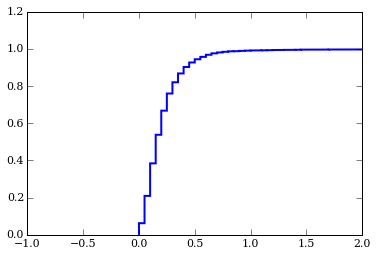

In [18]:
test=plt.hist(np.array(data1['v_comb_e']), bins=100, range=[0,5], normed=True, cumulative=True, histtype='step', lw=2)
plt.xlim(-1,2)
print test[1][np.where(test[0]>=0.98)[0][0]]

In [19]:
### Calculate UVW
UVW_temp=gal_uvw(distance=(data1['distance(pc)']), ra=data1['ra'], dec=data1['dec'],\
                 pmra=data1['pmra_ucac4'], pmdec=data1['pmdec_ucac4'], vrad=data1['v_comb'])
data1['U']=UVW_temp[0]*-1.0
data1['V']=UVW_temp[1]
data1['W']=UVW_temp[2]
data1['uvw_totvel']=np.sqrt(data1['U']**2+data1['V']**2+data1['W']**2)

In [20]:
### Calculate R, z from l,b, and distance
data1['xx']=8.-data1['distance(pc)']/1000.*np.cos(np.radians(data1['glat']))*np.cos(np.radians(data1['glon']))
data1['yy']=data1['distance(pc)']/1000.*np.cos(np.radians(data1['glat']))*np.sin(np.radians(data1['glon']))
data1['zz']=data1['distance(pc)']/1000.*np.sin(np.radians(data1['glat']))
data1['rr']=np.sqrt(data1['xx']**2.+data1['yy']**2.)

/Users/kschles/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/matplotlib/collections.py:571: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):



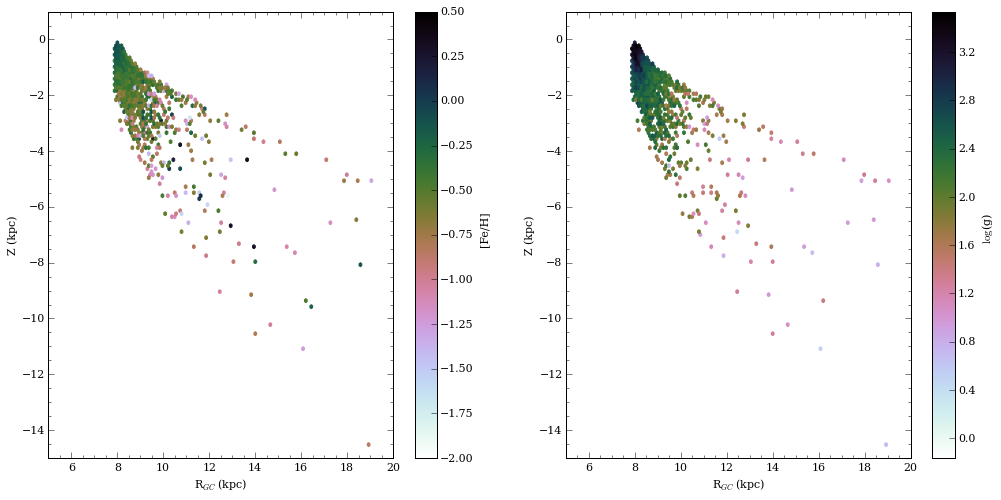

In [21]:
f, test1=plt.subplots(1,2, figsize=(17,8))
ax=data1.plot('rr', 'zz', kind='hexbin', ax=test1[0], \
              C='feh_cannon', reduce_C_function=np.mean, \
              gridsize=250, cmap='cubehelix_r', xlim=(5,20), \
              ylim=(-15, 1), grid=False, vmax=0.5, vmin=-2.0)
ax.minorticks_on()
ax.set_xlabel('R$_{GC}$ (kpc)')
ax.set_ylabel('Z (kpc)')
test1[0].text(1.25,0.55, '[Fe/H]', horizontalalignment='left', \
              verticalalignment='top', rotation='vertical', \
              transform=test1[0].transAxes, color='k')

ay=data1.plot('rr', 'zz', kind='hexbin', ax=test1[1], C='logg_cannon', \
              reduce_C_function=np.mean, gridsize=250, cmap='cubehelix_r', \
              xlim=(5,20), ylim=(-15, 1), grid=False)
ay.minorticks_on()
ay.set_xlabel('R$_{GC}$ (kpc)')
ay.set_ylabel('Z (kpc)')
test1[1].text(1.20,0.55, '$\log$(g)', horizontalalignment='left', verticalalignment='top', rotation='vertical', transform=test1[1].transAxes, color='k')

imgname='uvwcalc_duong_pilot.eps'
#plt.savefig(imgname)   



In [22]:
### I want to know how much the total velocity will vary with the uncertainties in proper motion and distance. To do this I run a monte carlo.
iteration=1000

for j in range(iteration): 
    gv1=np.random.standard_normal(len(data1['ra']))
    gv2=np.random.standard_normal(len(data1['ra']))
    gv3=np.random.standard_normal(len(data1['ra']))
    gv4=np.random.standard_normal(len(data1['ra']))
    gv5=np.random.standard_normal(len(data1['ra']))
    gv6=np.random.standard_normal(len(data1['ra']))

    pmra_err=data1['pmra_ucac4']+np.multiply(gv1,data1['e_pmra_ucac4'])
    pmdec_err=data1['pmdec_ucac4']+gv2*data1['e_pmdec_ucac4']
    rv_err=data1['v_comb']+gv3*data1['v_comb_e']
    dist_percent_err=np.multiply(gv4,0.20)
    dist_err=data1['distance(pc)']+np.multiply(dist_percent_err,data1['distance(pc)'])
    
    total_pm_err=(np.sqrt(pmra_err**2.+pmdec_err**2.))*(4.8481e-6/1000.)   #in radians
    vtrans_err=(np.tan(total_pm_err)*dist_err*1000.*3.08567e13)/(3.156e7)      #in km/s
    tvt_err=np.sqrt(np.add(vtrans_err**2,rv_err**2))

    xx_temp=8.-dist_err*np.cos(np.radians(data1['glat']))*np.cos(np.radians(data1['glon']))
    yy_temp=dist_err*np.cos(np.radians(data1['glat']))*np.sin(np.radians(data1['glon']))
    zz_temp=dist_err*np.sin(np.radians(data1['glat']))
    rr_temp=np.sqrt(xx_temp**2.+yy_temp**2.)

    UVW_temp2=gal_uvw(distance=(dist_err), ra=data1['ra'], dec=data1['dec'], pmra=pmra_err, pmdec=pmdec_err, vrad=rv_err)
    if j==0:
        ut=UVW_temp2[0]*-1.0
        vt=UVW_temp2[1]
        wt=UVW_temp2[2]
        rve=rv_err
    else:
        ut=np.c_[ut,(UVW_temp2[0])*-1.0]
        vt=np.c_[vt,UVW_temp2[1]]
        wt=np.c_[wt,UVW_temp2[2]]
        rve=np.c_[rve,rv_err]




In [23]:
u_std=[]
v_std=[]
w_std=[]

for i in range(len(data1)):
    if (i%500==0):
        print i 
    std_u=np.sqrt(np.mean((np.array(ut)[i] - data1['U'][i])**2))
    std_v=np.sqrt(np.mean((np.array(vt)[i] - data1['V'][i])**2))
    std_w=np.sqrt(np.mean((np.array(wt)[i] - data1['W'][i])**2))
    u_std.append(std_u)
    v_std.append(std_v)
    w_std.append(std_w)


0
500
1000
1500
2000
2500
3000
3500
4000
4500


In [24]:
data1['Ustd']=u_std
data1['Vstd']=v_std
data1['Wstd']=w_std

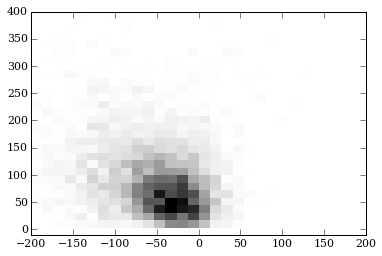

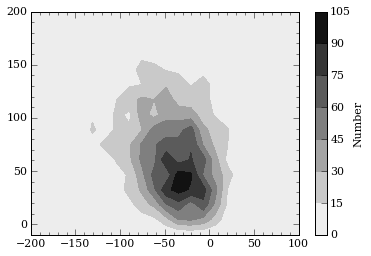

In [25]:
### Toomre Diagram
data1['UW']=np.sqrt(data1.U**2+data1.W**2)
plt.figure(1)
counts,xbins,ybins,image=plt.hist2d(np.array(data1['V']), np.array(data1['UW']), \
                                    range=[[-200.,200.],[-10.,400.]], cmap='binary', \
                                    bins=(30.,30.))

plt.figure()
cs=plt.contourf(counts.transpose(),extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()], \
                cmap='binary', zorder=2)
CB = plt.colorbar(cs, shrink=1.0, extend='both')
CB.set_label('Number')
plt.xlim(-200,100)
plt.ylim(-10,200)
plt.minorticks_on()



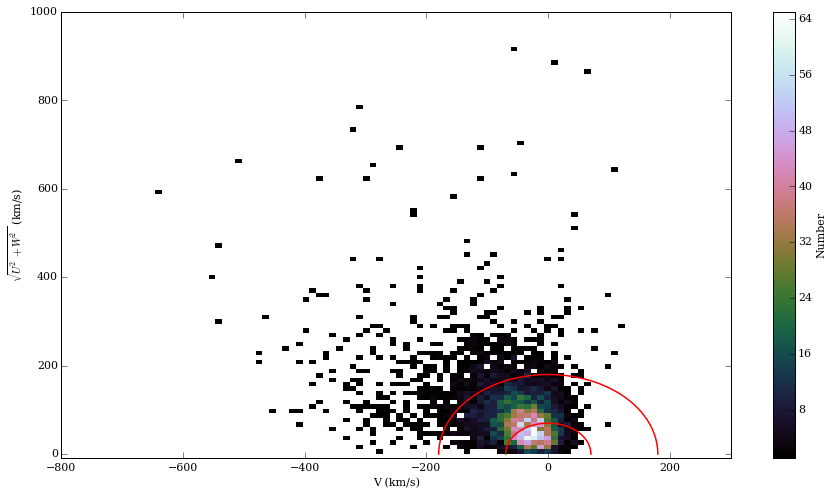

In [26]:
## Toomre diagram #2
f=plt.figure(figsize=(15,8))
plt.hist2d(data1['V'],data1['UW'],(100,100),range=[[-800.,300.],[-10.,1000.]],\
           cmin=1, cmap='cubehelix', zorder=2)
cb=plt.colorbar()
cb.set_label('Number')
x=np.linspace(-70.,70.,1000.)
y=np.sqrt(70.**2-x**2.)
plt.plot(x,y,'r-',linewidth=1.5, zorder=3)
x=np.linspace(-180.,180.,2000.)
y=np.sqrt(180.**2-x**2.)
plt.plot(x,y,'r-',linewidth=1.5, zorder=3)
plt.xlabel('V (km/s)')
plt.ylabel('$\sqrt{U^2+W^2}$ (km/s)')

<matplotlib.colorbar.Colorbar instance at 0x11747c368>

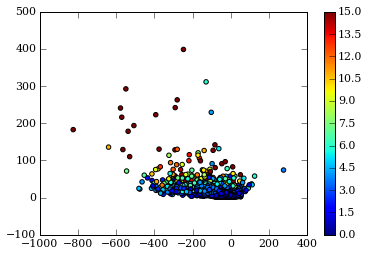

In [27]:
cs=plt.scatter(data1['V'], data1['Vstd'], c=data1['distance(pc)']/1000., vmin=0, vmax=15)
plt.colorbar(cs)

In [28]:
data1[['sobject_id', 'ra', 'dec', 'match', 'neighbor', 'fit_ra', 'fit_de', 'ndet', 'sep_arcsec',\
      'U', 'V', 'W', 'Ustd', 'Vstd', 'Wstd', 'xx', 'yy', 'zz', 'rr']].to_csv('duong_uvw_06022016.csv')